# Testing it with various models

## Import all the things we need

In [2]:
# setup the matplotlib graphics library and configure it to show 
# figures inline in the notebook
%matplotlib inline
from qutip import*
from scipy import *
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import QCLSolver.data as QCLData
import QCLSolver.solver as QCLS
import numpy as np
import matplotlib.pyplot as plt
import time

## Testing it in Jaynes-Cumming model

With the rotating-wave approximation

$$H_{\rm RWA} = \hbar \omega_c a^\dagger a + \frac{1}{2}\hbar\omega_a\sigma_z + \hbar g(a^\dagger\sigma_- + a\sigma_+)$$

### Build up the qutip version

In [12]:
wc = 1.0  * 2 * pi  # cavity frequency
wa = 1.0  * 2 * pi  # atom frequency
g  = 0.05 * 2 * pi  # coupling strength
kappa = 0.005       # cavity dissipation rate
gamma = 0.05        # atom dissipation rate
N = 15              # number of cavity fock states
n_th_a = 0.0        # avg number of thermal bath excitation

tlist = np.linspace(0,25,101)

In [13]:
# intial state
psi0 = tensor(basis(N,0), basis(2,1))    # start with an excited atom

# operators
a  = tensor(destroy(N), qeye(2))
sm = tensor(qeye(N), destroy(2))
# Hamiltonian
H = wc * a.dag() * a + wa * sm.dag() * sm + g * (a.dag() * sm + a * sm.dag())

In [14]:
c_ops = []

# cavity relaxation
rate1 = kappa * (1 + n_th_a)
c_ops.append(np.sqrt(rate1) * a)


rate2= kappa * n_th_a
c_ops.append(np.sqrt(rate2) * a.dag())

# qubit relaxation
rate3 = gamma
c_ops.append(np.sqrt(rate3) * sm)

In [15]:
tic=time.time()
output = mesolve(H, psi0, tlist, c_ops, [a.dag() * a, sm.dag() * sm])
toc=time.time()
t_qutip=toc-tic

In [16]:
n_c = output.expect[0]
n_a = output.expect[1]

### Build up the QCLS version

In [17]:
Hamilton=[['Aa',wc],['Bb',wa],['Ab',g],['aB',g]];print(Hamilton)
Co_ps=[['a',rate1],['A',rate2],['b',rate3]];print(Co_ps)
T_o=['Aa','Bb'];print(T_o)

[['Aa', 6.283185307179586], ['Bb', 6.283185307179586], ['Ab', 0.3141592653589793], ['aB', 0.3141592653589793]]
[['a', 0.005], ['A', 0.0], ['b', 0.05]]
['Aa', 'Bb']


In [18]:
data=QCLData.Data(Hamilton,Co_ps, T_o, 2)

In [19]:
tic=time.time()
sol2=QCLS.Solve(data, [0,1], (0,25), t_eval=tlist)
toc=time.time()
t_cluster=toc-tic

Text(0.5, 1.0, 'Vacuum Rabi oscillations')

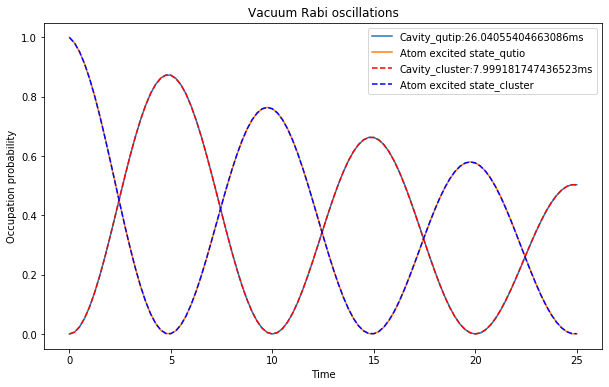

In [20]:
fig1, axes1 = plt.subplots(1, 1, figsize=(10,6))

axes1.plot(tlist, n_c,label="Cavity_qutip:"+str(1000*t_qutip)+'ms')
axes1.plot(tlist, n_a,label="Atom excited state_qutio")
axes1.plot(tlist, np.real(sol2.y[0]),color='red',linestyle='--',label="Cavity_cluster:"+str(1000*t_cluster)+'ms')
axes1.plot(tlist, np.real(sol2.y[1]),color='blue',linestyle='--',label="Atom excited state_cluster")
axes1.legend(loc=0)
axes1.set_xlabel('Time')
axes1.set_ylabel('Occupation probability')
axes1.set_title('Vacuum Rabi oscillations')

##  simulation of a two-qubit gate using a resonator as coupler

### Build up the qutip version

In [51]:
N = 10

wc = 5.0 * 2 * pi
w1 = 3.0 * 2 * pi
w2 = 2.0 * 2 * pi

g1 = 0.01 * 2 * pi
g2 = 0.0125 * 2 * pi

tlist = np.linspace(0, 100, 500)

width = 0.5

# resonant SQRT iSWAP gate
T0_1 = 20
T_gate_1 = (1*pi)/(4 * g1)

# resonant iSWAP gate
T0_2 = 60
T_gate_2 = (2*pi)/(4 * g2)

In [52]:
# cavity operators
a = tensor(destroy(N), qeye(2), qeye(2))
n = a.dag() * a

# operators for qubit 1

sm1 = tensor(qeye(N), destroy(2), qeye(2))
n1 = sm1.dag() * sm1
#sz1 = tensor(qeye(N), sigmaz(), qeye(2))
sz1=0.5*n1

# oeprators for qubit 2
sm2 = tensor(qeye(N), qeye(2), destroy(2))
n2 = sm2.dag() * sm2
#sz2 = tensor(qeye(N), qeye(2), sigmaz())
sz2=0.5*n2

In [53]:
# Hamiltonian using QuTiP
Hc = a.dag() * a
H1 = - 0.5 * sz1
H2 = - 0.5 * sz2
Hc1 = g1 * (a.dag() * sm1 + a * sm1.dag())
Hc2 = g2 * (a.dag() * sm2 + a * sm2.dag())

H = wc * Hc + w1 * H1 + w2 * H2 + Hc1 + Hc2 

In [54]:
# initial state: start with one of the qubits in its excited state
psi0 = tensor(basis(N,0),basis(2,1),basis(2,0))

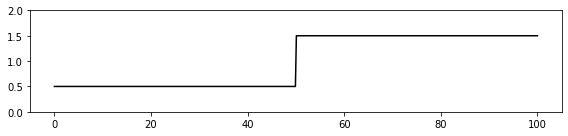

In [55]:
def step_t(w1, w2, t0, width, t):
    """
    Step function that goes from w1 to w2 at time t0
    as a function of t. 
    """
    return w1 + (w2 - w1) * (t > t0)


fig, axes = plt.subplots(1, 1, figsize=(8,2))
axes.plot(tlist, [step_t(0.5, 1.5, 50, 0.0, t) for t in tlist], 'k')
axes.set_ylim(0, 2)
fig.tight_layout()

In [56]:
def wc_t(t, args=None):
    return wc

def w1_t(t, args=None):
    return w1 + step_t(0.0, wc-w1, T0_1, width, t) - step_t(0.0, wc-w1, T0_1+T_gate_1, width, t)

def w2_t(t, args=None):
    return w2 + step_t(0.0, wc-w2, T0_2, width, t) - step_t(0.0, wc-w2, T0_2+T_gate_2, width, t)


H_t = [[Hc, wc_t], [H1, w1_t], [H2, w2_t], Hc1+Hc2]

In [57]:
tic=time.time()
output = mesolve(H_t, psi0, tlist, [], [n,n1,n2])
toc=time.time()
t_qutip=toc-tic

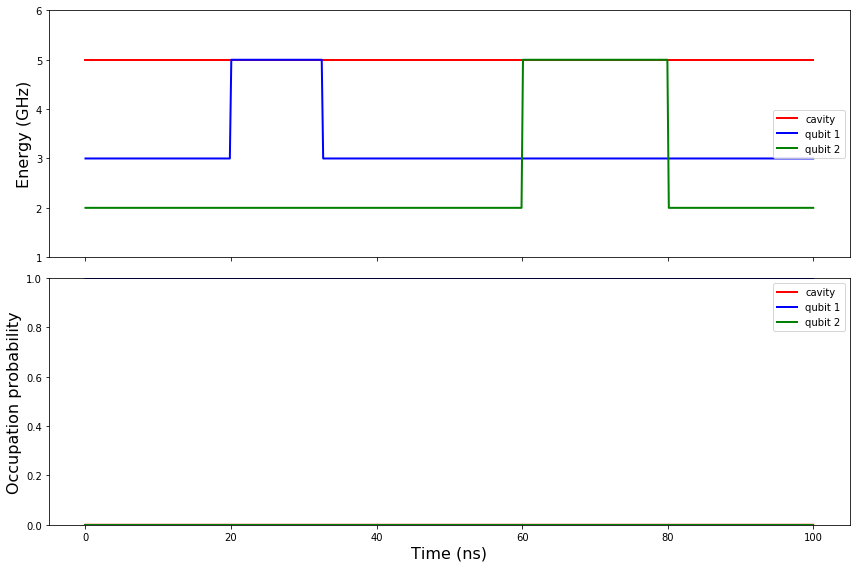

In [58]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,8))

axes[0].plot(tlist, np.array(list(map(wc_t, tlist))) / (2*pi), 'r', linewidth=2, label="cavity")
axes[0].plot(tlist, np.array(list(map(w1_t, tlist))) / (2*pi), 'b', linewidth=2, label="qubit 1")
axes[0].plot(tlist, np.array(list(map(w2_t, tlist))) / (2*pi), 'g', linewidth=2, label="qubit 2")
axes[0].set_ylim(1, 6)
axes[0].set_ylabel("Energy (GHz)", fontsize=16)
axes[0].legend()

axes[1].plot(tlist, np.real(output.expect[0]), 'r', linewidth=2, label="cavity")
axes[1].plot(tlist, np.real(output.expect[1]), 'b', linewidth=2, label="qubit 1")
axes[1].plot(tlist, np.real(output.expect[2]), 'g', linewidth=2, label="qubit 2")
axes[1].set_ylim(0, 1)

axes[1].set_xlabel("Time (ns)", fontsize=16)
axes[1].set_ylabel("Occupation probability", fontsize=16)
axes[1].legend()

fig.tight_layout()

### Build up the QCLS version

In [32]:
Hc='Aa'
H1='Bb'
H2='Cc'
Hc1_1='Ab'
Hc1_2='aB'
Hc2_1='Ac'
Hc2_2='aC'
T_o=['Aa','Bb','Cc']

In [33]:
def wc_t_c(t, args=None):
    return wc

def w1_t_c(t, args=None):
    return (w1 + step_t(0.0, wc-w1, T0_1, width, t) - step_t(0.0, wc-w1, T0_1+T_gate_1, width, t))*(-0.5)

def w2_t_c(t, args=None):
    return  ( w2 + step_t(0.0, wc-w2, T0_2, width, t) - step_t(0.0, wc-w2, T0_2+T_gate_2, width, t))*(-0.5)

H_t=[[Hc,wc],[H1,w1],[H2,w2],[Hc1_1,g1],[Hc1_2,g1],[Hc2_1,g2],[Hc2_2,g2]]
print(H_t)

[['Aa', 31.41592653589793], ['Bb', 18.84955592153876], ['Cc', 12.566370614359172], ['Ab', 0.06283185307179587], ['aB', 0.06283185307179587], ['Ac', 0.07853981633974483], ['aC', 0.07853981633974483]]


In [34]:
data=QCLData.Data(H_t, [], T_o, 2)

In [35]:
tic=time.time()
sol2=QCLS.Solve(data, [0,1,0], (0,100), t_eval=tlist)
toc=time.time()
t_cluster=toc-tic

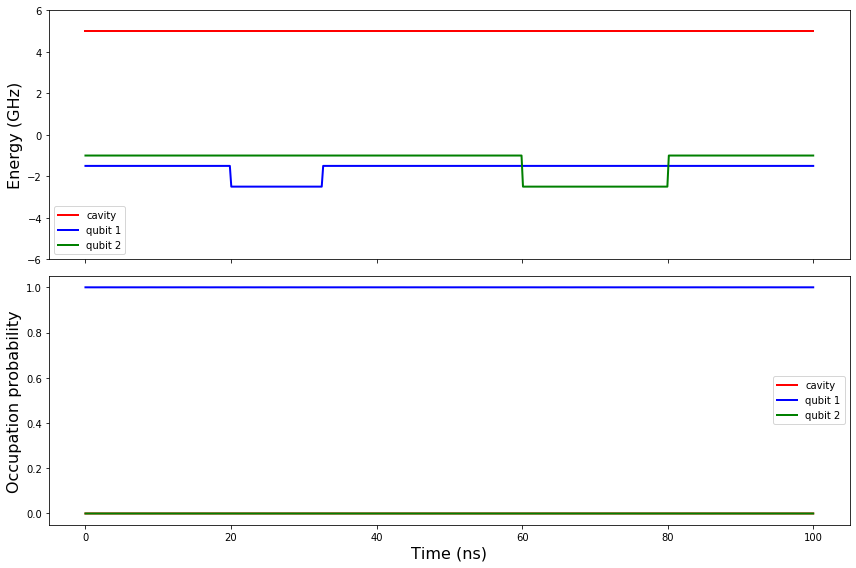

In [36]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,8))

axes[0].plot(tlist, np.array(list(map(wc_t_c, tlist))) / (2*pi), 'r', linewidth=2, label="cavity")
axes[0].plot(tlist, np.array(list(map(w1_t_c, tlist))) / (2*pi), 'b', linewidth=2, label="qubit 1")
axes[0].plot(tlist, np.array(list(map(w2_t_c, tlist))) / (2*pi), 'g', linewidth=2, label="qubit 2")
axes[0].set_ylim(-6, 6)
axes[0].set_ylabel("Energy (GHz)", fontsize=16)
axes[0].legend()

axes[1].plot(tlist, np.real(sol2.y[0]), 'r', linewidth=2, label="cavity")
axes[1].plot(tlist, np.real(sol2.y[1]), 'b', linewidth=2, label="qubit 1")
axes[1].plot(tlist, np.real(sol2.y[2]), 'g', linewidth=2, label="qubit 2")

axes[1].set_xlabel("Time (ns)", fontsize=16)
axes[1].set_ylabel("Occupation probability", fontsize=16)
axes[1].legend()

fig.tight_layout()